# Segger Innervation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from requirements import *
from segger.data.parquet._utils import (
    read_parquet_region,
    filter_transcripts,
    load_settings,
    get_polygons_from_xy,
)
from segger.data.utils import coo_to_dense_adj
from segger.training.segger_data_module import SeggerDataModule
from segger.prediction.predict import get_similarity_scores, load_model
from sg_utils.tl.xenium_utils import anndata_from_transcripts
from sg_utils.pp.preprocess_rapids import *
from sg_utils.pl.plot_embedding import plot_embedding
from sg_utils.pl.utils import lighten_color
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from sg_utils.pl.plot_segmentation_comparison import *
from sg_utils.tl.generate_boundaries import generate_boundaries
from sg_utils.pl.plot_segmentation import *
import dask_geopandas as dgpd
import torch
from cupyx.scipy.sparse import coo_matrix

## Run Connected Components

In [3]:
# Read and filter transcripts
uid = 'HDE46PBXJB'
seg_col = f'segger_cell_id_{uid}'
score_col = f'segger_score_{uid}'
cc_col = seg_col.replace('id', 'id_cc')

xe_settings = load_settings('xenium')
transcripts = pd.read_parquet(
    data_dir / 'labeled_transcripts.parquet',
    columns=[
        'transcript_id', seg_col, score_col,
        'x_location', 'y_location', 'feature_name',
    ],
)
transcripts.set_index('transcript_id', inplace=True)
transcripts = cudf.from_pandas(transcripts)

In [44]:
# Base directory to store Pytorch Lightning models
uid = 'HDE46PBXJB'
datasets_dir = (
    f'/data/peer/moormana/GitHub/dpeerlab/segger_dev/dev/figure_3_v2/data/'
    f'outputs/segger_v2/datasets/{uid}'
)
dm = SeggerDataModule(
    data_dir=datasets_dir,
    batch_size=1,
    num_workers=1, 
)
dm.setup()

In [49]:
dm_iter = iter(dm.train)

In [58]:
from segger.data.parquet.sample import STTile

In [89]:
pts = np.random.randint(0, 100, (10, 2))
dist, idx = STTile.get_kdtree_edge_index(pts, pts, 5, 5)

In [128]:
import torch
from torch_geometric.data import EdgeAttr
from torch_geometric.data import HeteroData

In [163]:
test = HeteroData()
test['a', 'to', 'b'].edge_index = edge_index

In [167]:
test.

<bound method BaseData.size of HeteroData(
  (a, to, b)={ edge_index=[2, 50] }
)>

In [131]:
# To sparse adjacency
edge_index = torch.vstack([
    torch.arange(idx.shape[0]).repeat_interleave(idx.shape[1]),
    torch.tensor(idx.flatten()),
])
edge_index = edge_index.long().contiguous()

In [157]:
edge_index = EdgeIndex(
    edge_index,
    sparse_size=idx.shape,
    sort_order='row',
)

In [162]:
edge_index.size()

torch.Size([2, 50])

In [88]:
idx

array([[9, 5, 1, 4, 6],
       [1, 8, 2, 7, 0],
       [3, 7, 2, 6, 0],
       [9, 4, 6, 5, 1],
       [8, 0, 2, 1, 7],
       [1, 8, 2, 5, 0],
       [8, 0, 1, 2, 7],
       [8, 1, 0, 2, 7],
       [4, 6, 1, 9, 2],
       [6, 4, 7, 2, 3]])

In [69]:
np.argwhere(mask)

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 5],
       [0, 6],
       [0, 7],
       [0, 8],
       [0, 9],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 6],
       [1, 7],
       [1, 8],
       [1, 9],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [2, 4],
       [2, 5],
       [2, 6],
       [2, 7],
       [2, 8],
       [2, 9],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3],
       [3, 4],
       [3, 5],
       [3, 6],
       [3, 7],
       [3, 8],
       [3, 9],
       [4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4],
       [4, 5],
       [4, 6],
       [4, 7],
       [4, 8],
       [4, 9],
       [5, 0],
       [5, 1],
       [5, 2],
       [5, 3],
       [5, 4],
       [5, 5],
       [5, 6],
       [5, 7],
       [5, 8],
       [5, 9],
       [6, 0],
       [6, 1],
       [6, 2],
       [6, 3],
       [6, 4],
       [6, 5],
       [6,

In [64]:
dist.shape

(10, 20)

In [5]:
uid = 'HDE46PBXJB'
models_dir = Path(
    f'/data/peer/moormana/GitHub/dpeerlab/segger_dev/dev/figure_3_v2/data/'
    f'outputs/segger_v2/models/{uid}/lightning_logs/version_0/checkpoints'
)
lit_segger = load_model(models_dir)

In [6]:
batch = next(dm.train_dataloader().__iter__())

In [7]:
import cupyx as cpx
from cupyx.scipy.sparse.csgraph import connected_components

def mask_sparse_coo_tensor(
    coo_tensor,
    mask,
    thresh: int = None,
    return_type: str = 'cupyx',
):
    coo_tensor = coo_tensor.coalesce()
    values = cp.array(coo_tensor.values())
    indices = cp.array(coo_tensor.indices())
    if thresh is not None:
        gt_thresh = values > thresh
        values = values[gt_thresh]
        indices = indices[:, gt_thresh]
    coo_mtx = cpx.scipy.sparse.coo_matrix(
        (values, (indices[0], indices[1])),
        shape=(len(mask), len(mask)),
    )
    coo_mtx = coo_mtx.tocsr()[mask].T[mask].T.tocoo()

    if return_type == 'cupyx':
        return coo_mtx
    else:
        coo_tensor = torch.sparse_coo_tensor(
            torch.tensor(cp.stack([coo_mtx.row, coo_mtx.col])),
            torch.tensor(coo_mtx.data),
        ).to('cuda')
        return coo_tensor

In [8]:
max_id = transcripts[cc_col].max() + 1

with torch.no_grad():
    
    # Get scores
    edge_index = batch['tx', 'neighbors', 'tx'].edge_index
    _, counts = torch.unique(edge_index[0], return_counts=True)
    batch['tx']['tx_field'] = torch.nn.utils.rnn.pad_packed_sequence(
        torch.nn.utils.rnn.PackedSequence(edge_index[1], counts.cpu()),
        padding_value=-1,
    )[0]
    scores = get_similarity_scores(
        lit_segger.model, batch, "tx", "tx", False
    )

    # Mask
    idx = cp.array(batch['tx'].id)
    mask = transcripts.loc[idx, score_col].lt(0.5)
    masked_scores = mask_sparse_coo_tensor(scores, mask, thresh=None)

torch.cuda.empty_cache()

# Get connected component labels
n, components = connected_components(masked_scores, directed=False)
labels, counts = np.unique(components, return_counts=True)
size_mask = np.isin(components, labels[counts > 50])
components = components[size_mask] + max_id

# Write to transcripts
col = f'{cc_col}_unfiltered'
transcripts[col] = transcripts[seg_col].copy()
transcripts.loc[mask.index[mask][size_mask], col] = components
max_id = components.max() + 1

In [11]:
max_id = transcripts[cc_col].max() + 1

with torch.no_grad():
    
    # Get scores
    edge_index = batch['tx', 'neighbors', 'tx'].edge_index
    _, counts = torch.unique(edge_index[0], return_counts=True)
    batch['tx']['tx_field'] = torch.nn.utils.rnn.pad_packed_sequence(
        torch.nn.utils.rnn.PackedSequence(edge_index[1], counts.cpu()),
        padding_value=-1,
    )[0]
    scores = get_similarity_scores(
        lit_segger.model, batch, "tx", "tx", False
    )

    # Mask
    idx = cp.array(batch['tx'].id)
    mask = transcripts.loc[idx, score_col].lt(0.5)
    masked_scores = mask_sparse_coo_tensor(scores, mask, thresh=45)

torch.cuda.empty_cache()

# Get connected component labels
n, components = connected_components(masked_scores, directed=False)
labels, counts = np.unique(components, return_counts=True)
size_mask = np.isin(components, labels[counts > 50])
components = components[size_mask] + max_id

# Write to transcripts
col = f'{cc_col}_filtered'
transcripts[col] = transcripts[seg_col].copy()
transcripts.loc[mask.index[mask][size_mask], col] = components
max_id = components.max() + 1

In [9]:
coords = batch['tx'].pos[:, :2].cpu()
region = shapely.box(
    *np.array(coords.min(0).values),
    *np.array(coords.max(0).values),
)
xmin, ymin, xmax, ymax = region.bounds

In [20]:
tx = transcripts[
    transcripts.x_location.between(xmin, xmax) & \
    transcripts.y_location.between(ymin, ymax)
].to_pandas()

In [21]:
mask = tx[score_col] < 0.5
tx.loc[mask, seg_col] = np.nan
tx[seg_col] = pd.Categorical(tx[seg_col])

for col in [
    f'{cc_col}_unfiltered',
    f'{cc_col}_filtered',
]:
    mask_1 = tx[seg_col].isna()
    mask_2 = tx[seg_col] == tx[col]
    tx.loc[mask_1 | mask_2, col] = np.nan
    tx[col] = pd.Categorical(tx[col])

In [22]:
# Get top markers used for classification
import celltypist as ct
ct_model = ct.Model.load(str(data_dir / '10x_nucleus_xenium_celltypist_model.pkl'))
coefs = pd.DataFrame(
    ct_model.classifier.coef_.T,
    index=ct_model.features,
    columns=ct_model.cell_types,
)
ct_map = coefs.idxmax(1)

# Color by cell type of transcript
tx['cell_type'] = pd.Categorical(
    tx['feature_name'].map(ct_map).fillna('Unassigned')
)

In [23]:
tx[f'{cc_col}_unfiltered'].isna().sum()

59463

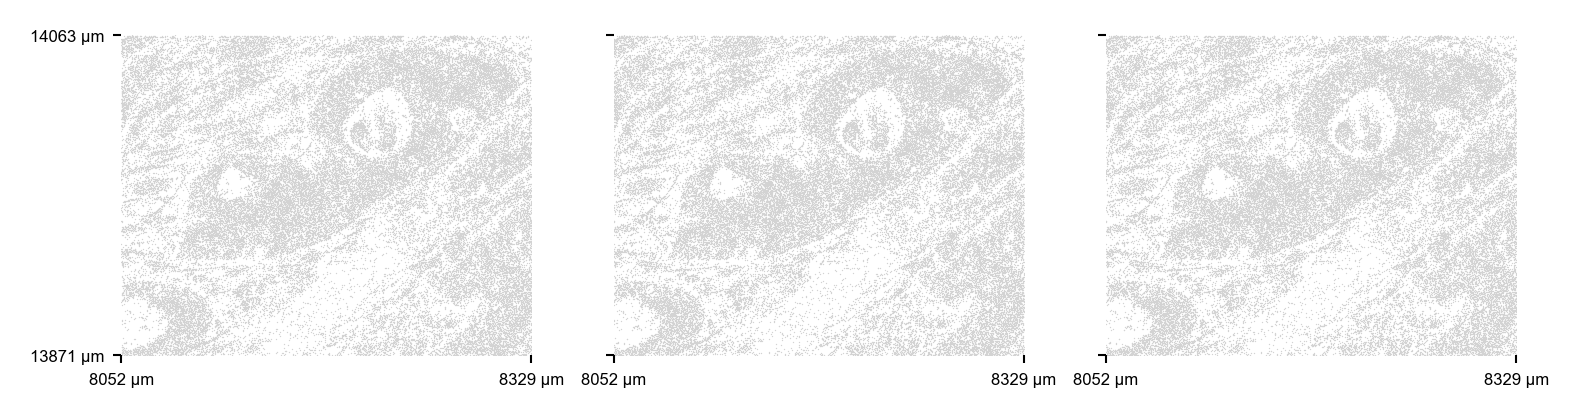

In [24]:
xmin, ymin, xmax, ymax = region.buffer(-20).bounds
aspect = (ymax - ymin) / (xmax - xmin)
fig, axes = plt.subplots(
    1, 3,
    figsize=(3 * 2, 2 * aspect),
    sharex=True, sharey=True
)

for ax in axes:
    sns.scatterplot(
        tx,
        x='x_location',
        y='y_location',
        lw=0,
        s=0.1,
        color='lightgray',
        legend=False,
        ax=ax,
    )

sns.scatterplot(
    tx[~tx[f'{cc_col}_unfiltered'].isna()],
    x='x_location',
    y='y_location',
    hue='cell_type',
    lw=0,
    s=0.2,
    legend=False,
    ax=axes[0],
    palette=named_colors,
)

sns.scatterplot(
    tx[~tx[f'{cc_col}_filtered'].isna()],
    x='x_location',
    y='y_location',
    hue=f'{cc_col}_filtered',
    lw=0,
    s=0.2,
    legend=False,
    ax=axes[1],
)

for ax in axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    format_ax(ax, region.buffer(-20))

In [10]:
coo_tensor = coo_tensor.coalesce()

In [11]:
import cupyx as cpx

In [14]:
coo_tensor.indices()

tensor([[    0,     0,     0,  ..., 61576, 61576, 61576],
        [    0,    72,   248,  ..., 61348, 61387, 61576]])

In [16]:
cpx.scipy.sparse.coo_matrix?

Init signature: cpx.scipy.sparse.coo_matrix(arg1, shape=None, dtype=None, copy=False)
Docstring:     
COOrdinate format sparse matrix.

This can be instantiated in several ways.

``coo_matrix(D)``
    ``D`` is a rank-2 :class:`cupy.ndarray`.

``coo_matrix(S)``
    ``S`` is another sparse matrix. It is equivalent to ``S.tocoo()``.

``coo_matrix((M, N), [dtype])``
    It constructs an empty matrix whose shape is ``(M, N)``. Default dtype
    is float64.

``coo_matrix((data, (row, col)))``
    All ``data``, ``row`` and ``col`` are one-dimenaional
    :class:`cupy.ndarray`.

Args:
    arg1: Arguments for the initializer.
    shape (tuple): Shape of a matrix. Its length must be two.
    dtype: Data type. It must be an argument of :class:`numpy.dtype`.
    copy (bool): If ``True``, copies of given data are always used.

.. seealso::
   :class:`scipy.sparse.coo_matrix`
File:           /lilac/data/peer/moormana/.micromamba/envs/segger-rapids-11.8/lib/python3.11/site-packages/cupyx/scipy/sparse

In [35]:
coo_tensor

tensor(indices=tensor([[   0,    0,    0,  ..., 5709, 5709, 5709],
                       [   0,    8,    9,  ..., 5673, 5690, 5709]]),
       values=tensor([35.6878, 37.1592, 36.8200,  ..., 31.2346, 33.5465,
                      31.4811]),
       device='cuda:0', size=(5710, 5710), nnz=162472, layout=torch.sparse_coo)

In [33]:
torch.tensor(cp.stack([coo_mtx.row, coo_mtx.col]))

tensor([[   0,    0,    0,  ..., 5709, 5709, 5709],
        [   0,    8,    9,  ..., 5673, 5690, 5709]], dtype=torch.int32)

In [39]:
masked_scores

tensor(indices=tensor([[   0,    0,    0,  ..., 5709, 5709, 5709],
                       [   0,    8,    9,  ..., 5673, 5690, 5709]]),
       values=tensor([35.6878, 37.1592, 36.8200,  ..., 31.2346, 33.5465,
                      31.4811]),
       device='cuda:0', size=(5710, 5710), nnz=162472, layout=torch.sparse_coo)

In [42]:
to_type = 'tx'
from_type = 'tx'

with torch.no_grad():

    batch = batch.to('cuda')

    # Get mask
    idx = cp.array(batch['tx'].id)
    mask = transcripts.loc[idx, seg_col].isna().values

    # Get embedding spaces from model
    y_hat = lit_segger.model(batch.x_dict, batch.edge_index_dict)
    
    # Filter neighbor index
    edge_index = batch['tx', 'neighbors', 'tx'].edge_index
    edge_index = cp.array(edge_index)
    mtx = coo_matrix(
        (cp.ones(edge_index.shape[1]), (edge_index[0], edge_index[1]))
    )
    mtx = mtx.tocsr()[mask].T[mask].T.tocoo()
    nbr_idx = torch.stack(
        [torch.tensor(mtx.row), torch.tensor(mtx.col)]
    ).to('cuda')

    # Similarity of each 'from_type' to 'to_type' neighbors
    _, counts = torch.unique(nbr_idx[0], return_counts=True)
    splits = torch.split(
        y_hat[to_type][torch.tensor(mask)][nbr_idx[1]],
        tuple(counts)
    )
    mtx_a = torch.nn.utils.rnn.pad_sequence(splits).swapaxes(0, 1)
    mtx_b = y_hat[to_type][torch.tensor(mask)].unsqueeze(-1)
    similarity = torch.bmm(mtx_a, mtx_b).swapaxes(0, 1)
    similarity = torch.nn.utils.rnn.unpad_sequence(similarity, counts)
    sparse_sim = torch.sparse_coo_tensor(
        nbr_idx, 
        torch.concat(similarity).flatten()
    )
    
torch.cuda.empty_cache()

In [45]:
to_type = 'tx'
from_type = 'tx'

with torch.no_grad():

    batch.to('cuda')

    # Get mask
    #idx = cp.array(batch['tx'].id)
    #mask = transcripts.loc[idx, seg_col].isna().values

    # Get embedding spaces from model
    y_hat = lit_segger.model(batch.x_dict, batch.edge_index_dict)
    
    # Filter neighbor index
    nbr_idx = batch['tx', 'neighbors', 'tx'].edge_index

    # Similarity of each 'from_type' to 'to_type' neighbors
    _, counts = torch.unique(nbr_idx[0], return_counts=True)
    splits = torch.split(y_hat[to_type][nbr_idx[1]], tuple(counts))
    mtx_a = torch.nn.utils.rnn.pad_sequence(splits).swapaxes(0, 1)
    mtx_b = y_hat[to_type].unsqueeze(-1)
    similarity = torch.bmm(mtx_a, mtx_b).swapaxes(0, 1)
    similarity = torch.nn.utils.rnn.unpad_sequence(similarity, counts)
    sparse_sim = torch.sparse_coo_tensor(
        nbr_idx, 
        torch.concat(similarity).flatten()
    )
    
torch.cuda.empty_cache()

In [73]:
edge_index = batch['tx', 'neighbors', 'tx'].edge_index

In [74]:
edge_index

tensor([[    0,     0,     0,  ..., 65718, 65718, 65718],
        [    0,  3476,  4812,  ..., 61451, 54254, 46227]], device='cuda:0')

In [48]:
splits = torch.split(y_hat[to_type][nbr_idx[1]], tuple(counts))

In [67]:
%%timeit -r 2 -n 2
edge_index = batch['tx', 'neighbors', 'tx'].edge_index
_, counts = torch.unique(edge_index[0], return_counts=True)
splits = torch.split(edge_index[1], tuple(counts))
torch.nn.utils.rnn.pack_sequence(splits)

1.2 s ± 520 μs per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [76]:
torch.nn.utils.rnn.pad_packed_sequence

<function torch.nn.utils.rnn.pad_packed_sequence(sequence: torch.nn.utils.rnn.PackedSequence, batch_first: bool = False, padding_value: float = 0.0, total_length: Optional[int] = None) -> Tuple[torch.Tensor, torch.Tensor]>

In [71]:
torch.nn.utils.rnn.PackedSequence(edge_index[1], counts.cpu())

PackedSequence(data=array([    0,  3476,  4812, ..., 61451, 54254, 46227]), batch_sizes=tensor([40, 40, 40,  ..., 40, 40, 40]), sorted_indices=None, unsorted_indices=None)

In [72]:
edge_index[1]

array([    0,  3476,  4812, ..., 61451, 54254, 46227])

In [31]:
similarity.shape

torch.Size([5842, 40, 1])

In [18]:
y_hat = lit_segger.model(batch.x_dict, batch.edge_index_dict)['tx']
y_hat = y_hat[mask]

TypeError: len() of unsized object

In [ ]:
edge_index = batch['tx', 'neighbors', 'tx'].edge_index

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [4341, 16] but got: [68266, 16].

In [477]:
s = torch.split(y_hat['tx'][nbr_idx[1]], tuple(counts))

In [478]:
s.T.shape

AttributeError: 'tuple' object has no attribute 'T'

In [469]:
splits[0].shape

torch.Size([27, 16])

torch.Size([40, 4341, 16])

In [446]:
%%timeit -r 3 -n 3
edge_index = batch['tx', 'neighbors', 'tx'].edge_index
idx = torch.argwhere(torch.tensor(mask)).flatten().to('cuda')
in_idx = torch.isin(edge_index, idx).all(0)
masked_index = edge_index[:, in_idx]
uniques, row = torch.unique(masked_index[0], return_inverse=True)

col = torch.zeros(masked_index.shape[1]).to('cuda').int()
for i, u in enumerate(uniques):
    col += torch.where(masked_index[1]==u, i, 0)
nbr_idx_2 = torch.stack([row, col])

221 ms ± 2.79 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [437]:
(nbr_idx_2[0] == nbr_idx[0]).all()

tensor(True, device='cuda:0')

In [441]:
nbr_idx_2[1][nbr_idx_2[0] == 0].sort()

torch.return_types.sort(
values=tensor([  0,   2,   5,  14,  17,  19,  25,  33,  40,  48,  63,  67,  68,  87,
         88,  89,  99, 114, 117, 121, 128, 129, 130, 144, 162, 175, 176],
       device='cuda:0'),
indices=tensor([ 0, 12,  7, 25, 11, 14, 23, 16, 26, 17, 24,  5,  9, 10,  2, 22,  3,  6,
        13,  8,  4, 18, 15, 20, 21,  1, 19], device='cuda:0'))

In [444]:
nbr_idx[1][nbr_idx[0] == 0].sort()

torch.return_types.sort(
values=tensor([  0,   2,   5,  14,  17,  19,  25,  33,  40,  48,  63,  67,  68,  87,
         88,  89,  99, 114, 117, 121, 128, 129, 130, 144, 162, 175, 176],
       device='cuda:0', dtype=torch.int32),
indices=tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26], device='cuda:0'))

In [421]:
(nbr_idx[0] != nbr_idx_2[0]).sum()

tensor(84427, device='cuda:0')

In [288]:
edge_index.sparse_mask(sparse_mask.bool()).coalesce()

tensor(indices=tensor([[    6,     6,     6,  ..., 68208, 68208, 68208],
                       [    6,  2657,  1563,  ..., 66844, 66444, 66678]]),
       values=tensor([ 1.,  0.,  0.,  ..., 34.,  0.,  0.]),
       device='cuda:0', size=(68266, 68266), nnz=106240, layout=torch.sparse_coo)

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [258]:
shape = 

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [203]:
from cupyx.scipy.sparse import coo_matrix

In [215]:
torch.ones(edge_index.shape[1]).shape

torch.Size([2730640])

In [229]:
from cupyx.scipy.sparse import csr_matrix

In [232]:
csr_matrix((1, (torch.tensor([0, 1, 2]), torch.tensor([0, 1, 1]))))

ValueError: row, column, and data arrays must be 1-D

In [234]:
edge_index = EdgeIndex(edge_index).sort_by('row').values
edge_coo = edge_index.to_sparse_coo()

In [235]:
edge_coo.sparse_mask(

tensor(indices=tensor([[    0,     0,     0,  ..., 68265, 68265, 68265],
                       [    0,    46,   374,  ..., 68211, 67842, 67537]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       device='cuda:0', size=(68266, 68266), nnz=2730640,
       layout=torch.sparse_coo)

In [165]:
edge_index = batch['tx', 'neighbors', 'tx'].edge_index

In [186]:
unique, row_idx = torch.unique(edge_index[0][in_idx], return_inverse=True)

In [190]:
edge_index[1][in_idx]

tensor([    6,  2657,  1563,  ..., 66844, 66444, 66678], device='cuda:0')

In [196]:
in_idx

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [195]:
edge_index[in_idx]

IndexError: The shape of the mask [2730640] at index 0 does not match the shape of the indexed tensor [2, 2730640] at index 0

In [138]:
type(edge_index)

tuple

In [136]:
edge_index[idx]

TypeError: only integer tensors of a single element can be converted to an index

In [79]:
coo_to_dense_adj(
    edge_index,
    num_nodes=batch['tx'].id.shape[0],
)

In [82]:
to_type = from_type = 'tx'

In [83]:
m = torch.nn.ZeroPad2d((0, 0, 0, 1))  # pad bottom with zeros

In [90]:
y_hat[to_type][edge_index[1].T].shape

torch.Size([106240, 16])

In [84]:
similarity = torch.bmm(
    m(y_hat[to_type])[nbr_idx],    # 'to' x 'from' neighbors x embed
    y_hat[from_type].unsqueeze(-1) # 'to' x embed x 1
)

In [86]:
similarity.shape

torch.Size([68266, 40, 1])

In [57]:
import torch
idx = torch.argwhere(torch.tensor(mask)).flatten()

RuntimeError: torch.take_along_dim(): input and indices should have the same number of dimensions, but got 2 dimensions for input, and 1 dimensions for indices

In [62]:
edge_index.masked_select?

Docstring:
masked_select(mask) -> Tensor

See :func:`torch.masked_select`
Type:      builtin_function_or_method

In [8]:


idx = batch['tx'].id
mask = transcripts.loc[cp.array(idx).astype('uint64'), seg_col].isna()
mask = mask.values.get()

scores = scores.coalesce()
scores = sp.sparse.coo_array(
    (vals, scores.indices().numpy()),
    shape=scores.shape
).tocsr()[mask].tocsc()[:, mask]

vals = scores.values().numpy()
vals = np.where(vals < 45, 0, vals)

In [27]:
scores = scores.tocsr()[mask].tocsc()[:, mask]

In [34]:
scores[]

array([60.72201 , 65.04792 , 64.38599 , ..., 28.541662, 27.414902,
       27.063583], dtype=float32)

In [35]:
scores > 0.5

<4341x4341 sparse array of type '<class 'numpy.bool_'>'
	with 106240 stored elements in Compressed Sparse Column format>

In [21]:
import torch

In [26]:
num_nodes = None
num_nbrs = None

In [30]:
uniques, counts = torch.unique(edge_index[0], return_counts=True)

In [34]:
y_hat = lit_segger.model(batch.x_dict, batch.edge_index_dict)

In [50]:
y_hat['tx'].shape

torch.Size([101355, 16])

4054200

In [61]:
A = y_hat['tx'][edge_index[1]].reshape([101355, 40, 16])

In [62]:
B = y_hat['tx'][batch['tx']['tx_field']]

In [64]:
(A == B).all()

tensor(True, device='cuda:0')

In [31]:
torch.split(edge_index[1], counts)

TypeError: split_with_sizes(): argument 'split_sizes' (position 2) must be tuple of ints, not Tensor

In [28]:
%%timeit -r 1 -n 3
uniques, counts = torch.unique(edge_index[0], return_counts=True)
num_nodes = uniques.max() + 1
num_nbrs = counts.max()
nbr_idx = torch.full((num_nodes, num_nbrs), -1)

2.83 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [521]:
edge_index = batch['tx', 'neighbors', 'bd'].edge_index
batch['tx']['bd_field'] = coo_to_dense_adj(
    edge_index,
    num_nodes=batch['tx'].id.shape[0],
)
scores_tx_bd = get_similarity_scores(lit_segger.model, batch, "tx", "bd")

In [6]:
coords = batch['tx'].pos[:, :2].cpu()
region = shapely.box(
    *np.array(coords.min(0).values),
    *np.array(coords.max(0).values),
)
# Read and filter transcripts
xe_settings = load_settings('xenium')
transcripts = read_parquet_region(
    data_dir / 'labeled_transcripts.parquet',
    *xe_settings.transcripts.xy,
    bounds=region.buffer(5),
    extra_columns=['segger_score_HDE46PBXJB', 'transcript_id'],
)
transcripts.set_index('transcript_id', inplace=True)

In [ ]:
cupyx.scipy.sparse.

In [522]:
scores_tx_bd = scores_tx_bd.coalesce()
scores_tx_bd_sp = sp.sparse.coo_array(
    (scores_tx_bd.values().numpy(), scores_tx_bd.indices().numpy()),
    shape=scores_tx_bd.shape
)

In [525]:
# For each transcript which isn't assigned to a nucleus
# what is its maximum score within assigned transcripts
mask_asgn = (scores_tx_bd_sp.max(1) > 0.5).todense().flatten()
max_asgn = scores_tx_tx_sp.tocsc()[:, mask_asgn].max(1).todense()
max_unas = scores_tx_tx_sp.tocsc()[:, ~mask_asgn].max(1).todense()

score_idx = np.array(batch['tx'].id.cpu()).astype('uint64')
transcripts.loc[score_idx[~mask_asgn], 'Assigned Score'] = max_asgn[~mask_asgn]
transcripts['Assigned Score'] = transcripts['Assigned Score'].astype(float)
transcripts.loc[score_idx[~mask_asgn], 'Unassigned Score'] = max_unas[~mask_asgn]
transcripts['Unassigned Score'] = transcripts['Unassigned Score'].astype(float)

masks = [
    transcripts.loc[score_idx, 'Unassigned Score'].gt(-1),
    transcripts.loc[score_idx, 'Unassigned Score'].gt(0.25),
    transcripts.loc[score_idx, 'Assigned Score'].lt(0.99) & transcripts.loc[score_idx, 'Unassigned Score'].gt(0.25),
]

for i, mask in enumerate(masks):
    scores = scores_tx_tx_sp.tocsr()[mask].tocoo()
    scores = scores.tocsc()[:, mask].tocoo()
    n, comps = cc(scores, connection="weak", directed=False)
    
    labels, counts = np.unique(comps, return_counts=True)
    size_mask = np.isin(comps, labels[counts > 30])
    transcripts[f'Component {i}'] = np.nan
    transcripts.loc[score_idx[mask][size_mask], f'Component {i}'] = comps[size_mask]

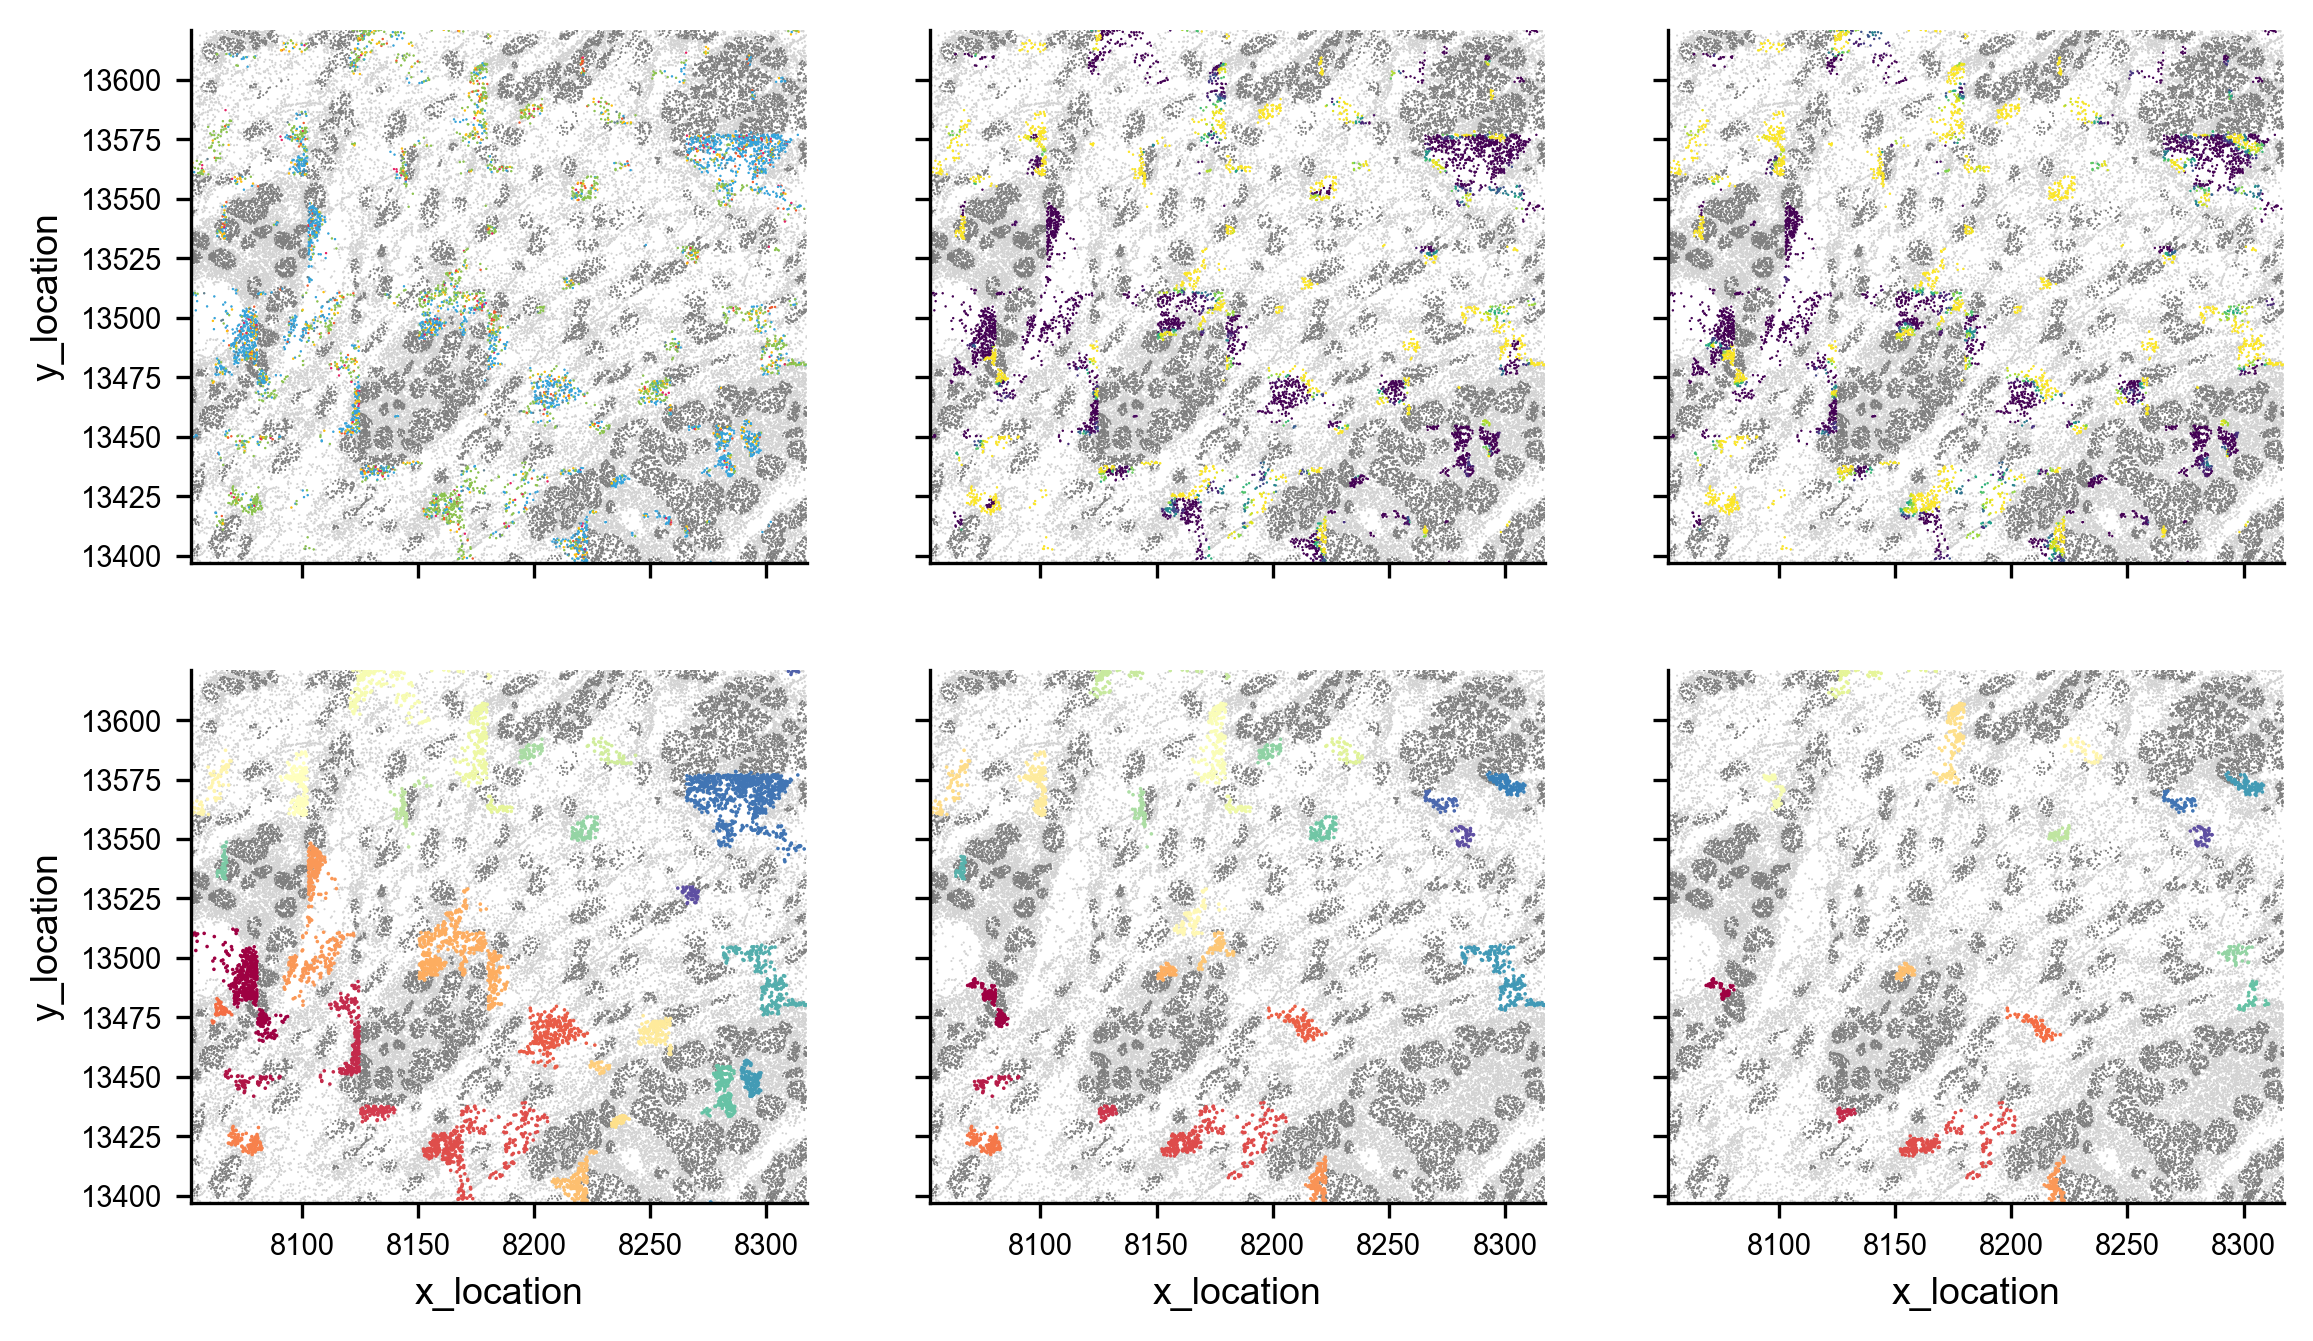

In [526]:


xmin, ymin, xmax, ymax = region.buffer(-20).bounds
data = transcripts[
    transcripts.x_location.between(xmin, xmax) & \
    transcripts.y_location.between(ymin, ymax)
]
aspect = (ymax - ymin) / (xmax - xmin)
fig, axes = plt.subplots(2, 3, figsize=(3 * 3, 2 * 3 * aspect), sharex=True, sharey=True)
axes = axes.flat

for ax in axes:
    sns.scatterplot(
        data,
        x='x_location',
        y='y_location',
        hue='overlaps_nucleus',
        lw=0,
        s=0.25,
        palette=['lightgray', 'gray'],
        legend=False,
        ax=ax,
    )

data = data[~data['Unassigned Score'].isna()]

axes[0].scatter(
    data['x_location'],
    data['y_location'],
    c=[named_colors[l] for l in data['cell_type']],
    vmin=0,
    vmax=1,
    lw=0,
    s=0.33,
)

axes[1].scatter(
    data['x_location'],
    data['y_location'],
    c=data['Assigned Score'],
    vmin=0,
    vmax=1,
    lw=0,
    s=0.33,
)

axes[2].scatter(
    data['x_location'],
    data['y_location'],
    c=data['Unassigned Score'],
    vmin=0,
    vmax=1,
    lw=0,
    s=0.33,
)

data_0 = data[~data['Component 0'].isna()]
axes[3].scatter(
    data_0['x_location'],
    data_0['y_location'],
    c=pd.factorize(data_0['Component 0'])[0],
    cmap='Spectral',
    lw=0,
    s=0.75,
)

data_1 = data[~data['Component 1'].isna()]
axes[4].scatter(
    data_1['x_location'],
    data_1['y_location'],
    c=pd.factorize(data_1['Component 1'])[0],
    cmap='Spectral',
    lw=0,
    s=0.75,
)

data_2 = data[~data['Component 2'].isna()]
axes[5].scatter(
    data_2['x_location'],
    data_2['y_location'],
    c=pd.factorize(data_2['Component 2'])[0],
    cmap='Spectral',
    lw=0,
    s=0.75,
)

for ax in axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

In [33]:
from scipy.sparse.csgraph import connected_components as cc

In [42]:
batch['tx'].id[mask].cpu()

tensor([281483566648389, 281483566648399, 281483566648403,  ...,
        281483567200594, 281483567200608, 281483567200624], device='cuda:0')

In [41]:
mask.shape

(72495,)

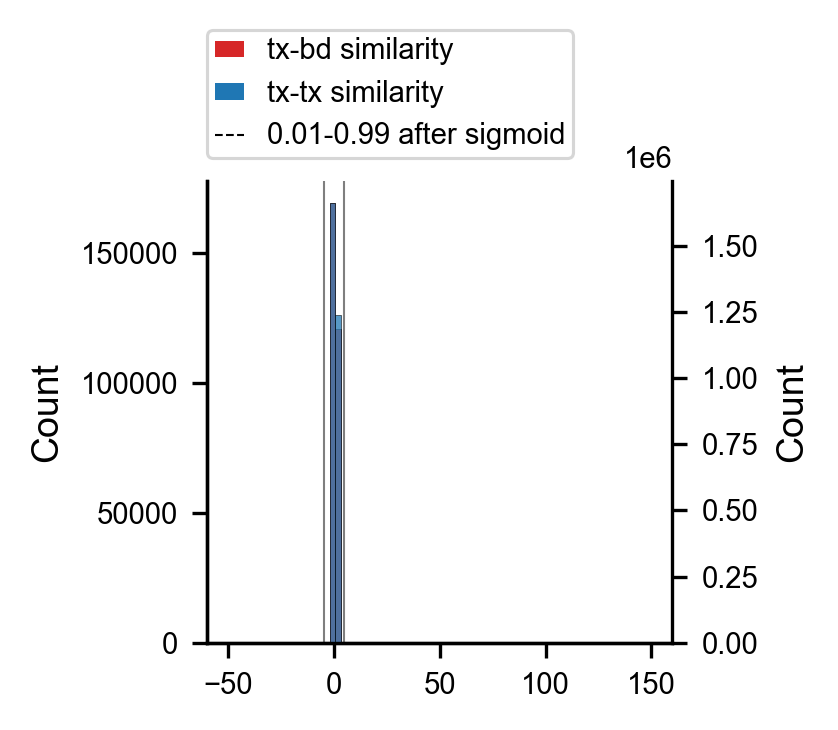

In [36]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(2,2))
sns.histplot(
    np.array(scores_tx_bd.coalesce().values()),
    bins=np.linspace(-50, 150, 80),
    color='tab:red',
    label='tx-bd similarity'
)
ax_2 = ax.twinx()
sns.histplot(
    np.array(scores_tx_tx.coalesce().values()),
    bins=np.linspace(-50, 150, 80),
    ax=ax_2,
    color='tab:blue',
    label='tx-tx similarity'
)
ax.spines['right'].set_visible(True)

elements = [
    Patch(facecolor='tab:red', label='tx-bd similarity'),
    Patch(facecolor='tab:blue', label='tx-tx similarity'),
    Line2D([0], [0], linestyle='--', lw=0.5, c='k', label='0.01-0.99 after sigmoid')
]

ax.axvline(4.6, lw=0.5, c='k', alpha=0.5)
ax.axvline(-4.6, lw=0.5, c='k', alpha=0.5)

ax.legend(handles=elements, loc=[0, 1.05])

In [46]:
for loader in [
    dm.train_dataloader(),
    dm.test_dataloader(),
    dm.val_dataloader()
]:
    for batch in loader:
        edge_index = batch['tx', 'neighbors', 'tx'].edge_index
        batch['tx']['tx_field'] = coo_to_dense_adj(
            edge_index,
            num_nodes=batch['tx'].id.shape[0],
        )
        scores = get_similarity_scores(lit_segger.model, batch, "tx", "tx")
        print((scores.coalesce().values() != 1).sum() / len(scores.coalesce().values()))

tensor(1.)
tensor(1.)


KeyboardInterrupt: 

In [47]:
vals = np.array(scores.coalesce().values())

In [67]:
scores.coalesce().values().mean()

tensor(66.4467)

In [72]:
scores.add(-scores.coalesce().values().mean())

RuntimeError: add(sparse, dense) is not supported. Use add(dense, sparse) instead.

In [69]:
 + scores

RuntimeError: add: expected 'self' and 'other' to have same size, but self has size [] while other has size [89680, 89680] (FYI: dense-sparse addition does not currently support broadcasting)